# USAD
## Importing packages

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

In [2]:
!ls ../data

test.csv  train.csv


## Reading data

In [3]:
df = pd.read_csv('../../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df.columns = df.columns.str.strip()
df = df.drop(columns=['Timestamp', 'Normal/Attack'])
grouping_array = np.arange(len(df)) // 5
df = df.groupby(grouping_array).median()

### Processing data

In [4]:
window_size = 12
input_size = window_size * 51
latent_space = 10 * window_size
epochs = 100

In [5]:
mm = MinMaxScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda:0


In [7]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size, device):
        self.data = dataframe
        self.window_size = window_size
        self.device = device

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(self.device)
        return features

In [8]:
train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 7096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Setting up the model structure

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.relu = nn.ReLU(True)
        self.fc2 = nn.Linear(input_size // 2, input_size // 4)
        self.fc3 = nn.Linear(input_size // 4, hidden_size)
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        return out


class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder):        
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(True)
        self.fc1 = nn.Linear(hidden_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 2)
        self.fc3 = nn.Linear(input_size // 2, input_size)
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [10]:
shared_encoder = Encoder(input_size, latent_space)
AE1 = AutoEncoder(input_size, latent_space, shared_encoder)
AE2 = AutoEncoder(input_size, latent_space, shared_encoder)

In [11]:
shared_encoder.to(device)
AE1.to(device)
AE2.to(device)

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=612, out_features=306, bias=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=306, out_features=153, bias=True)
    (fc3): Linear(in_features=153, out_features=120, bias=True)
  )
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=120, out_features=153, bias=True)
  (fc2): Linear(in_features=153, out_features=306, bias=True)
  (fc3): Linear(in_features=306, out_features=612, bias=True)
)

In [12]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

## Training the model

### Training

In [13]:
AE1_val_history = []
AE2_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        features = features.view(features.shape[0], -1)
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            features = features.view(features.shape[0], -1)
        
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.0469, AE2: 0.0483
Train loss: AE1 0.2457, AE2 0.2164
Epoch: 1 ---> Val loss: AE1 0.0382, AE2: 0.0006
Train loss: AE1 0.0733, AE2 -0.0056
Epoch: 2 ---> Val loss: AE1 0.1842, AE2: -0.1005
Train loss: AE1 0.1653, AE2 -0.0827
Epoch: 3 ---> Val loss: AE1 0.0462, AE2: -0.0263
Train loss: AE1 0.1413, AE2 -0.0532
Epoch: 4 ---> Val loss: AE1 0.2907, AE2: -0.2018
Train loss: AE1 0.2748, AE2 -0.1405
Epoch: 5 ---> Val loss: AE1 0.3370, AE2: -0.2403
Train loss: AE1 0.3240, AE2 -0.2337
Epoch: 6 ---> Val loss: AE1 0.3122, AE2: -0.2436
Train loss: AE1 0.3290, AE2 -0.2496
Epoch: 7 ---> Val loss: AE1 0.2573, AE2: -0.2361
Train loss: AE1 0.2878, AE2 -0.2423
Epoch: 8 ---> Val loss: AE1 0.2402, AE2: -0.2279
Train loss: AE1 0.2478, AE2 -0.2297
Epoch: 9 ---> Val loss: AE1 0.2345, AE2: -0.2238
Train loss: AE1 0.2402, AE2 -0.2266
Epoch: 10 ---> Val loss: AE1 0.2319, AE2: -0.2224
Train loss: AE1 0.2327, AE2 -0.2209
Epoch: 11 ---> Val loss: AE1 0.2346, AE2: -0.2280
Train loss: AE1 0

In [14]:
def plot_history(losses1, losses2):
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.savefig('Training_history.png')
    plt.show()

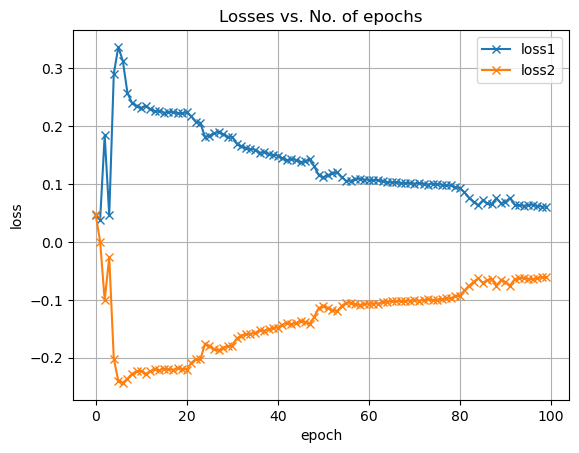

In [15]:
plot_history(AE1_val_history, AE2_val_history)

In [16]:
# torch.save(AE1.state_dict(), 'my_USAD_without_downsampling_AE1_hidden_10_random.pth')
# torch.save(AE2.state_dict(), 'my_USAD_without_downsampling_AE2_hidden_10_random.pth')

In [17]:
# AE1.load_state_dict(torch.load('my_USAD_without_downsampling_AE1_100_hidden.pth'))
# AE2.load_state_dict(torch.load('my_USAD_without_downsampling_AE2_100_hidden.pth'))

## Testing

In [18]:
df2 = pd.read_csv('../../../Projects/data/SWaT_Dataset_Attack_v0.csv')
df2.columns = df2.columns.str.strip()
df2['attack'] = df2['Normal/Attack'].replace({'Normal': 0, 'Attack': 1, 'A ttack': 1})
df2 = df2.drop(columns=['Timestamp', 'Normal/Attack'])
grouping_array = np.arange(len(df2)) // 5
df2 = df2.groupby(grouping_array).median()
labels = df2['attack']
df2 = df2.drop(columns=['attack'])

/tmp/ipykernel_130774/3058025915.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['attack'] = df2['Normal/Attack'].replace({'Normal': 0, 'Attack': 1, 'A ttack': 1})


In [19]:
df2

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,2.489191,522.88600,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.443085,2.0,...,0.308619,2.0,1.0,250.8812,1.649953,189.6148,0.000128,1.0,1.0,1.0
1,2.649970,524.10280,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.441803,2.0,...,0.308619,2.0,1.0,250.7530,1.649953,189.5027,0.000128,1.0,1.0,1.0
2,2.616020,523.43550,2.0,2.0,1.0,262.0161,8.390669,328.6337,2.441803,2.0,...,0.306633,2.0,1.0,251.1856,1.649953,189.9994,0.000128,1.0,1.0,1.0
3,2.534350,522.68970,2.0,2.0,1.0,262.0161,8.390669,328.6081,2.439881,2.0,...,0.307850,2.0,1.0,251.1856,1.649953,189.8872,0.000128,1.0,1.0,1.0
4,2.458764,522.88600,2.0,2.0,1.0,262.0161,8.390669,328.6337,2.439881,2.0,...,0.307978,2.0,1.0,251.1856,1.649953,189.8872,0.000128,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89979,2.431221,519.23550,2.0,2.0,1.0,168.0979,8.643489,301.8457,2.459488,2.0,...,0.308426,2.0,1.0,251.3618,0.977157,189.0381,0.000000,1.0,1.0,1.0
89980,2.538833,517.42990,2.0,2.0,1.0,168.0979,8.643489,301.8457,2.460898,2.0,...,0.308426,2.0,1.0,251.2176,0.849005,188.8779,0.000000,1.0,1.0,1.0
89981,2.656055,516.56630,2.0,2.0,1.0,168.0979,8.642528,301.8457,2.462051,2.0,...,0.308426,2.0,1.0,251.2176,0.945119,189.0381,0.000000,1.0,1.0,1.0
89982,2.606091,518.17570,2.0,2.0,1.0,168.0979,8.639965,301.9226,2.459488,2.0,...,0.306569,2.0,1.0,251.3779,0.945119,189.1182,0.000000,1.0,1.0,1.0


In [20]:
test_normalized = pd.DataFrame(mm.transform(df2))

In [21]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [22]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.view(batch.shape[0], -1)
            w1=AE1(batch)
            w2=AE2(w1)
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [23]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [24]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [25]:
np.sum(y_test)

11306.0

In [26]:
results=testing(test_loader)

In [27]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                       results[-1].flatten().detach().cpu().numpy()])

In [28]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

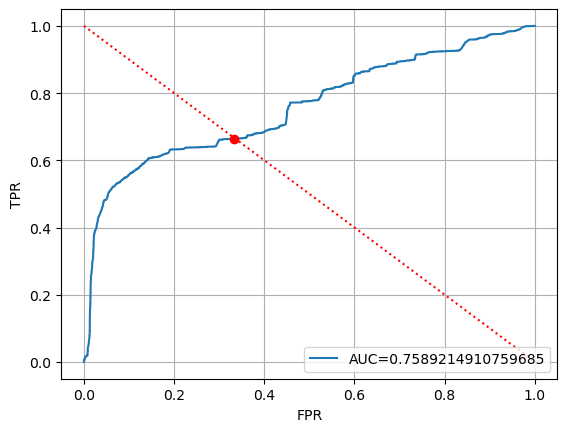

In [29]:
threshold = ROC(y_test,y_pred)

In [30]:
threshold

array([0.3857151], dtype=float32)

best: 0.463265306122449 F1: 0.5352897289231533


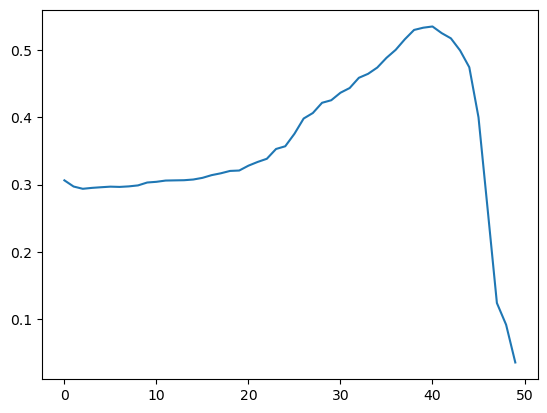

In [31]:
ff = 0
f_history = []
initial_y = 0.3
best = -1
for inc in np.linspace(0, 0.2, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

# Try adjust point

In [32]:
best

0.163265306122449